In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib
# matplotlib.use('qt5agg')
import matplotlib.pyplot as plt
import time
import numpy as np
import query_db
import composite as comp
import matplotlib.gridspec as gridspec

In [3]:
%matplotlib inline

In [7]:
# query_max = ["SELECT * from Supernovae inner join Photometry ON Supernovae.SN = Photometry.SN where phase >= -3 and phase <= 3 and (dm15_source > 0 or dm15_from_fits > 0) and NED_host between 1 and 9",
#              "SELECT * from Supernovae inner join Photometry ON Supernovae.SN = Photometry.SN where phase >= -3 and phase <= 3 and (dm15_source > 0 or dm15_from_fits > 0) and NED_host >= 10"]
query_max = ["SELECT * from Supernovae inner join Photometry ON Supernovae.SN = Photometry.SN where NED_host between 1 and 9 and (dm15_source > 0 or dm15_from_fits > 0) and phase between -100 and 800",
             "SELECT * from Supernovae inner join Photometry ON Supernovae.SN = Photometry.SN where NED_host >= 10 and (dm15_source > 0 or dm15_from_fits > 0) and phase between -100 and 800"]

In [8]:
# SN_Array = composite.grab(query_max, multi_epoch = False, make_corr = True)

In [9]:
# comps, sn_arrays, boot_sn_arrays = query_db.main(len(query_max), query_max, boot='b', medmean=1, selection = 'max_coverage', verbose=False, gini_balance=True)
comps, sn_arrays, boot_sn_arrays = query_db.main(len(query_max), query_max, boot='nb', medmean=1, selection = 'max_coverage', verbose=False, gini_balance=False)

SQL Query: SELECT * from Supernovae inner join Photometry ON Supernovae.SN = Photometry.SN where NED_host between 1 and 9 and (dm15_source > 0 or dm15_from_fits > 0) and phase between -100 and 800
ERROR:  2003hv_20040901_51567_151964_00.dat None
ERROR:  sn1992a-19920116.220-iue.flm None
173 questionable files currently ignored
Generate variance failed for:  [u'2005cf_20050601_3243_9720_00.dat', u'sn2005cf-20050603-hst.flm', u'sn2005cf-20050605-hst.flm', u'sn2005cf-20050607-hst.flm', u'sn2005cf-20050611-hst.flm', u'sn2005cf-20050614-hst.flm']
(65, 'questionable spectra removed', 789, 'spectra left')
(0, 'Peculiar Ias removed', 789, 'spectra left')
730 spectra with host corrections
173 questionable files currently ignored
66 valid SNe found
Arrays cleaned
0 spectra may have telluric contamination
66 SNs with host corrections
Creating composite...
Done.
SQL Query: SELECT * from Supernovae inner join Photometry ON Supernovae.SN = Photometry.SN where NED_host >= 10 and (dm15_source > 0 or d

In [10]:
SN_Array_E = sn_arrays[0]
SN_Array_S = sn_arrays[1]
for SN in SN_Array_E:
    if SN.ned_host is None:
        print SN.name
for SN in SN_Array_S:
    if SN.ned_host is None:
        print SN.name

In [11]:
dm15s_E = []
dm15s_S = []
weights_E = []
weights_S = []

for SN in SN_Array_E:
    if SN.dm15_source != None:
        dm15s_E.append(SN.dm15_source)
        weights_E.append(np.nansum(SN.ivar[SN.x1:SN.x2]))
    elif SN.dm15_from_fits != None:
        dm15s_E.append(SN.dm15_from_fits)
        weights_E.append(np.nansum(SN.ivar[SN.x1:SN.x2]))
        
for SN in SN_Array_S:
    if SN.dm15_source != None:
        dm15s_S.append(SN.dm15_source)
        weights_S.append(np.nansum(SN.ivar[SN.x1:SN.x2]))
    elif SN.dm15_from_fits != None:
        dm15s_S.append(SN.dm15_from_fits)
        weights_S.append(np.nansum(SN.ivar[SN.x1:SN.x2]))

1.0988808524
1.43831932467

1.05655440838
1.21766348376


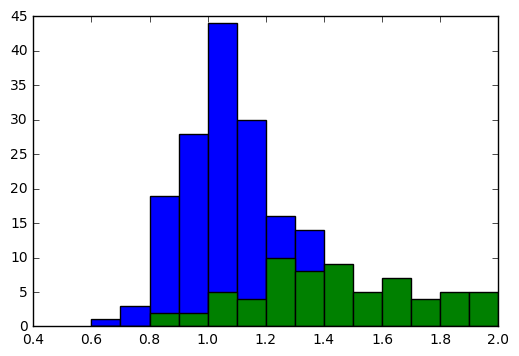

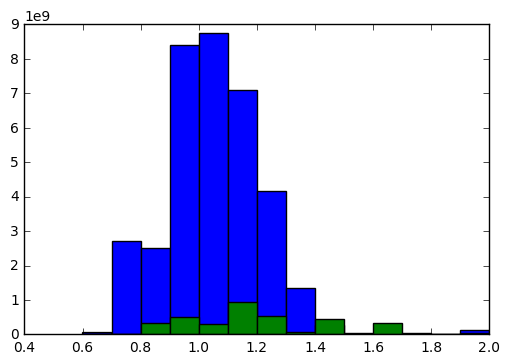

In [12]:
print np.average(dm15s_S)
print np.average(dm15s_E)
print
print np.average(dm15s_S, weights=weights_S)
print np.average(dm15s_E, weights=weights_E)

bins = np.linspace(.6,2.,num = 15, retstep=True)[0]
n_S, bins_S, patches = plt.hist(dm15s_S, bins=bins)
n_E, bins_E, patches = plt.hist(dm15s_E, bins=bins)
plt.show()
n, bins, patches = plt.hist(dm15s_S, bins=bins, weights=weights_S)
n, bins, patches = plt.hist(dm15s_E, bins=bins, weights=weights_E)
plt.show()

In [13]:
from scipy.optimize import curve_fit
import copy

In [14]:
def gaus(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

In [15]:
centers = (bins[:-1] + bins[1:])/2.
popt_S,pcov_S = curve_fit(gaus,centers,n_S,p0=[1,np.average(dm15s_S),np.std(dm15s_S)])
popt_E,pcov_E = curve_fit(gaus,centers,n_E,p0=[1,np.average(dm15s_E),np.std(dm15s_E)])

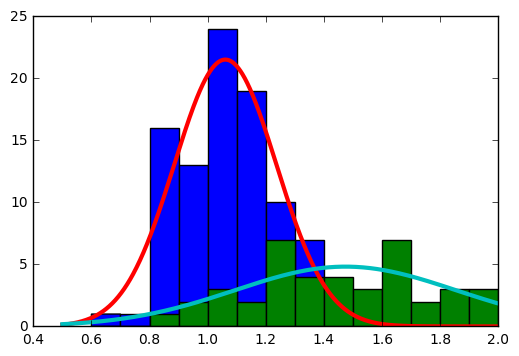

In [17]:
bins = np.linspace(.6,2.,num = 15, retstep=True)[0]
x = np.linspace(.5,2.2, num=1000)
n_S, bins_S, patches = plt.hist(dm15s_S, bins=bins)
n_E, bins_E, patches = plt.hist(dm15s_E, bins=bins)
gaus_S = gaus(x,*popt_S)
gaus_E = gaus(x,*popt_E)
plt.plot(x,gaus_S, linewidth=3)
plt.plot(x,gaus_E, linewidth=3)
plt.xlim([.4,2.])
plt.show()

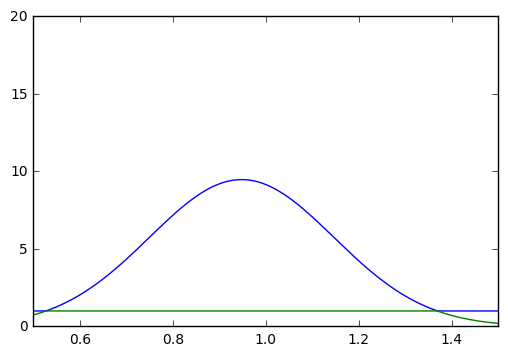

In [18]:
ratio = gaus_S/gaus_E
ratio_S = copy.deepcopy(ratio)
inds_S = np.where(ratio < 1)
ratio_S[inds_S] = 1.
ratio_E = copy.deepcopy(ratio)
inds_E = np.where(ratio > 1)
ratio_E[inds_E] = 1.
plt.plot(x,ratio_S)
plt.plot(x,ratio_E)
plt.xlim([.5,1.5])
plt.ylim([0,20])
plt.show()

In [19]:
print np.interp(1.0, x, ratio_S)
print np.interp(1.0, x, ratio_E)

9.1543126358
1.0


In [20]:
for SN in SN_Array_E:
    if SN.dm15_source != None:
        scale = np.interp(SN.dm15_source, x, ratio_E)
        print 'E: ', SN.dm15_source, scale
    elif SN.dm15_from_fits != None:
        scale = np.interp(SN.dm15_from_fits, x, ratio_E)
        print 'E: ', SN.dm15_from_fits, scale
    SN.ivar = SN.ivar/scale

for SN in SN_Array_S:
    if SN.dm15_source != None:
        scale = np.interp(SN.dm15_source, x, ratio_S)
        print 'S: ', SN.dm15_source, scale
    elif SN.dm15_from_fits != None:
        scale = np.interp(SN.dm15_from_fits, x, ratio_S)
        print 'S: ', SN.dm15_from_fits, scale
    SN.ivar = SN.ivar/scale

E:  0.85 1.0
E:  1.9 9.4542222297e-05
E:  1.62 0.0305328097251
E:  0.99 1.0
E:  1.44 0.437425476484
E:  1.41 0.629249167821
E:  1.1 1.0
E:  1.41 0.629249167821
E:  1.22957865079 1.0
E:  1.0 1.0
E:  1.9352579802 3.96594654773e-05
E:  1.26659174257 1.0
E:  1.55 0.0948087380647
E:  1.6 0.0427464667645
E:  1.64106422829 0.0211895373929
E:  1.37 0.986134340448
E:  1.26 1.0
E:  1.51 0.171313981125
E:  1.26 1.0
E:  1.08 1.0
E:  1.79 0.0011601488501
E:  1.88 0.000152577492957
E:  1.32 1.0
E:  1.48 0.25994172199
E:  1.69 0.00868175800531
E:  1.56 0.0812581910889
E:  1.77 0.00177090473486
E:  1.22 1.0
E:  1.30686535341 1.0
E:  1.27 1.0
E:  1.63 0.0257060843573
E:  1.69 0.00868175800531
E:  1.87 0.000193109738704
E:  1.89 0.000120258205242
E:  1.05273249926 1.0
E:  1.91637192734 6.34076049748e-05
E:  0.979300806419 1.0
E:  1.13369017264 1.0
E:  1.21360534365 1.0
E:  1.39953907584 0.710490089559
E:  1.69 0.00868175800531
S:  0.94 9.46624816427
S:  1.16 5.35273112871
S:  1.15 5.64180834351
S:  1.05

In [21]:
template_E = comp.supernova()
template_S = comp.supernova()

In [24]:
lengths_E = []
for SN in SN_Array_E:
    lengths_E.append(len(SN.flux[SN.x1:SN.x2]))
temp = [SN for SN in SN_Array_E if len(SN.flux[SN.x1:SN.x2]) == max(lengths_E)]
test = temp[0]
template_E = copy.deepcopy(test)
template_E.spec_bin = comp.spectra_per_bin(SN_Array_E)
template_E, boots_E = comp.create_composite(SN_Array_E, False, template_E, 1, gini_balance=False)

lengths_S = []
for SN in SN_Array_S:
    lengths_S.append(len(SN.flux[SN.x1:SN.x2]))
temp = [SN for SN in SN_Array_S if len(SN.flux[SN.x1:SN.x2]) == max(lengths_S)]
test = temp[0]
template_S = copy.deepcopy(test)
template_S.spec_bin = comp.spectra_per_bin(SN_Array_S)
template_S, boots_E = comp.create_composite(SN_Array_S, False, template_S, 1, gini_balance=False)

Creating composite...
Done.
Creating composite...
Done.


query_db.py:676: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if comp.RMSE != None:


-0.427849822339
1.87175112474
0.0164812745915
0.610005333842
1.07648202017
0.00971317866002


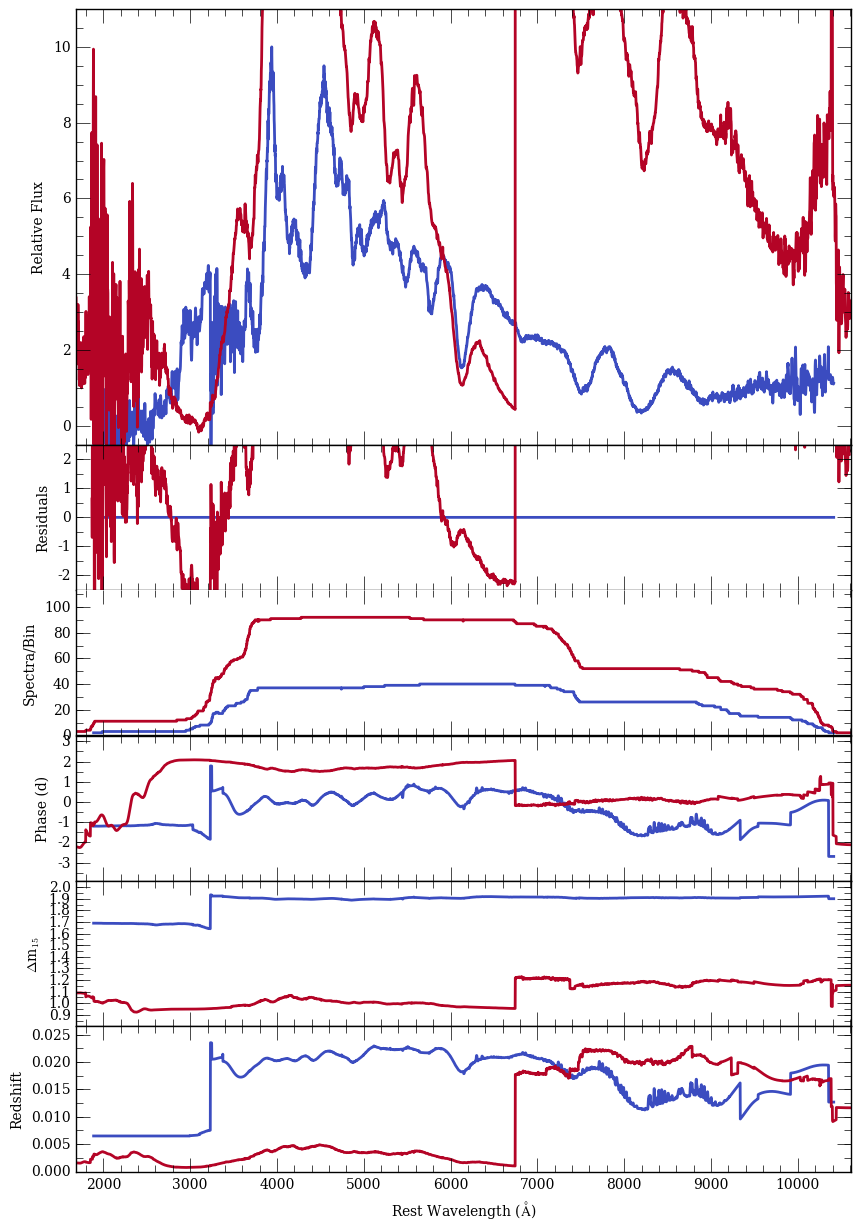

In [26]:
query_db.comparison_plot([template_E, template_S], scale_type=False, min_num_show=2)